# **Computer Vision Project**

**PART - A**

**1.1 a - Import Libraries:**

In [1]:
# used to supress display of warnings
import warnings

# Pandas is used for data manipulation and analysis
import pandas as pd

# Numpy is used for large, multi-dimensional arrays and matrices, along with mathematical operators on these arrays
import numpy as np

# Matplotlib is a data visualization library for 2D plots of arrays, built on NumPy arrays
# and designed to work with the broader SciPy stack
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot

# Seaborn is based on matplotlib, which aids in drawing attractive and informative statistical graphics.
import seaborn as sns

# train_test_split is a function in Sklearn model selection for splitting data arrays into two subsets: for training data and for testing data.
from sklearn.model_selection import train_test_split

# StanderScaler is a function in Sklearn preprocessing that standardizes features by removing the mean and scaling to unit variance.
from sklearn.preprocessing import StandardScaler

# TensorFlow is a software library for deep learning, a branch of artificial intelligence that uses neural networks with many hidden layers
import tensorflow as tf
# tensorflow.keras is a class in TensorFlow that allows you to create a Sequential model for a plain stack of layers where each layer has exactly one input tensor and one output tensor1.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Flatten

from tensorflow.keras import optimizers

import random
from tensorflow.keras import backend
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log

import os

!pip install opencv-python
import cv2

C:\Users\valkya\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**1.1 a - Read the ‘Images.npy’ as DataFrame**

In [2]:
# To read a npy file as DataFrame and store them in a separate variable as 'df'.
df = np.load('Images.npy',allow_pickle=True)

In [3]:
df[0][1] # To get the first row and second column of the df i.e selecting a specific cell in the DataFrame

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

**1.1 b - Split the data into Features(X) & labels(Y). Unify shape of all the images.**

In [4]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT =  IMAGE_WIDTH = 224 #Image size(heigt*width) be 224*224

masks = np.zeros((int(df.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(df.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(df.shape[0]):
    img = df[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
        img = img[:, :, :3]
    except:
        continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in df[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

**1.1 c - Split the data into train and test[400:9].**

In [5]:
X_train = X[:400] # Original Image
y_train = masks[:400] # Mask Image

In [6]:
X_test = X[400:]
y_test = masks[400:]

In [7]:
print(X_train.shape)
print(X_test.shape)

(400, 224, 224, 3)
(9, 224, 224, 3)


In [8]:
print(y_train.shape)
print(y_test.shape)

(400, 224, 224)
(9, 224, 224)


In [9]:
len(X_train)

400

**1.1 d - Select random image from the train data and display original image and masked image.**

134


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


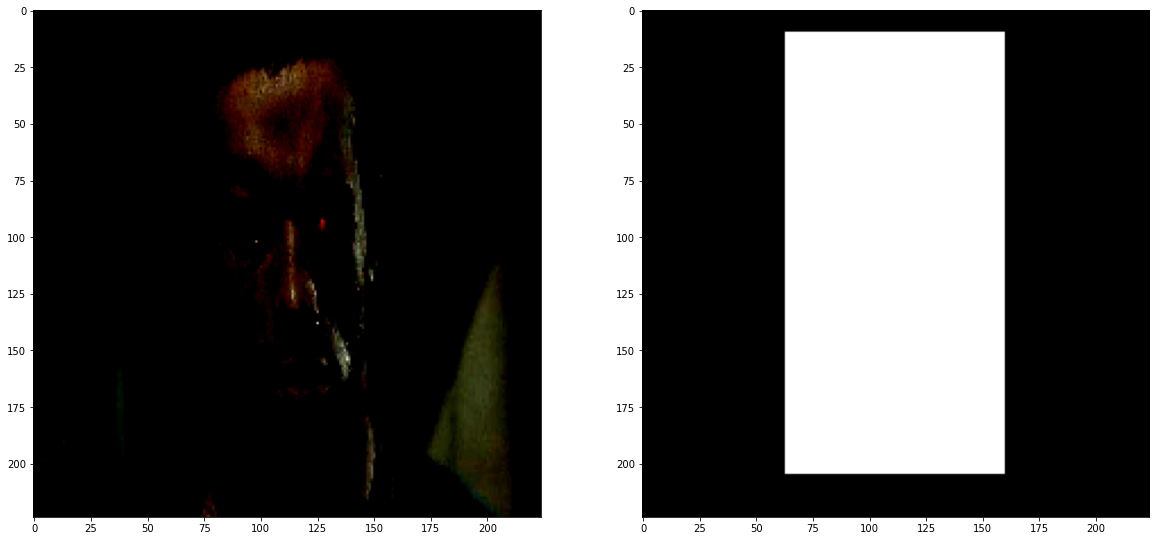

In [10]:
n = random.choice(range(len(X_train)))
print(n)
plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.imshow(X_train[n],cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(masks[n],cmap='gray')

plt.show()

**1.2 a - Design a face mask detection model.**

In [11]:
# To build a model importing the libraries required
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

In [12]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")
    
    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output
    
    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

In [13]:
model = create_model()

(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


In [14]:
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']        

                                                                                                  
 conv_pw_5 (Conv2D)          (None, 28, 28, 256)          65536     ['conv_dw_5_relu[0][0]']      
                                                                                                  
 conv_pw_5_bn (BatchNormali  (None, 28, 28, 256)          1024      ['conv_pw_5[0][0]']           
 zation)                                                                                          
                                                                                                  
 conv_pw_5_relu (ReLU)       (None, 28, 28, 256)          0         ['conv_pw_5_bn[0][0]']        
                                                                                                  
 conv_pad_6 (ZeroPadding2D)  (None, 29, 29, 256)          0         ['conv_pw_5_relu[0][0]']      
                                                                                                  
 conv_dw_6

 conv_pw_10_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_pw_10_bn[0][0]']       
                                                                                                  
 conv_dw_11 (DepthwiseConv2  (None, 14, 14, 512)          4608      ['conv_pw_10_relu[0][0]']     
 D)                                                                                               
                                                                                                  
 conv_dw_11_bn (BatchNormal  (None, 14, 14, 512)          2048      ['conv_dw_11[0][0]']          
 ization)                                                                                         
                                                                                                  
 conv_dw_11_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_dw_11_bn[0][0]']       
                                                                                                  
 conv_pw_1

__________________________________________________________________________________________________


**1.2 b - Design your own Dice Coefficient and Loss function.**

In [15]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

In [16]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

**1.2 c - Train and tune the model as required.**

In [17]:
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient]) # To intiate the model with metrics as dice_coefficient.

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [19]:
model.fit(X_train, y_train, epochs=10, batch_size=2, callbacks=[checkpoint, reduce_lr, stop]) # To fit the model with earlystopping process

Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 1.0522 - dice_coefficient: 0.5431
Epoch 1: loss improved from inf to 1.05221, saving model to model-1.05.h5
200/200 [==============================] - 1071s 5s/step - loss: 1.0522 - dice_coefficient: 0.5431 - lr: 0.0010
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.7417 - dice_coefficient: 0.6261
Epoch 2: loss improved from 1.05221 to 0.74165, saving model to model-0.74.h5
200/200 [==============================] - 961s 5s/step - loss: 0.7417 - dice_coefficient: 0.6261 - lr: 0.0010
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 0.6443 - dice_coefficient: 0.6637
Epoch 3: loss improved from 0.74165 to 0.64431, saving model to model-0.64.h5
200/200 [==============================] - 978s 5s/step - loss: 0.6443 - dice_coefficient: 0.6637 - lr: 0.0010
Epoch 4/10
200/200 [==============================] - ETA: 0s - loss: 0.5575 - dice_coefficient: 0.6946
Epoch 4: loss improv

**1.2 d - Evaluate and share insights on performance of the model.**

In [20]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 34s 34s/step - loss: 0.5366 - dice_coefficient: 0.7099


[0.5366078019142151, 0.7099044322967529]

**Insights:-**

- As per performance tested on test images, Loss is 0.5366 and dice_coefficient is 0.7099. For, now model was stable.
- To improve performance further would be suggested to randomize the training data is a good practice to enhance the generalization and robustness of model. It's a relatively simple step that can lead to improvements, especially when you suspect that the order of the data might introduce bias or affect the model's convergence.

**1.3 - Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.**

In [21]:
test_img = X_test[3] #This line selects the 4th image (index 3, as Python uses 0-based indexing) from the X_test dataset and assigns it to the variable test_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


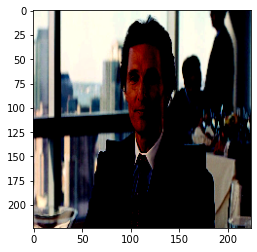

In [22]:
plt.imshow(test_img) #This line uses the imshow function from the matplotlib.pyplot library to display the selected test image

In [23]:
test_img = cv2.resize(test_img,(IMAGE_HEIGHT,IMAGE_WIDTH))

In [24]:
test_img.shape #This line checks and prints the shape of the resized test_img, which will show the dimensions of the image

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


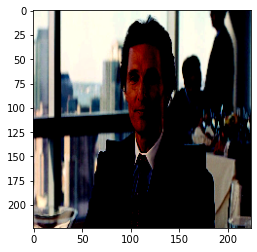

In [25]:
plt.imshow(test_img)#This line uses the imshow function from the matplotlib.pyplot library to display the selected test image

**This line adds a new dimension to the test_img array at axis 0, effectively converting it from a 3D array (height, width, channels) to a 4D array with a batch dimension (1, height, width, channels). This is often done when working with models that expect batched input.**

In [26]:
test_img_mask = np.expand_dims(test_img,0)

**This line uses the model to make predictions on the test_img_mask. The predictions are stored in pred_mask. The 1.0 * part is to convert the predictions to floating-point numbers.**

In [27]:
pred_mask = 1.0 * (model.predict(test_img_mask))

1/1 [==============================] - 16s 16s/step


In [28]:
pred_mask = pred_mask.swapaxes(0,1) #The purpose of this operation depends on the expected format of the predictions. It might be required to match the shape of the image.
pred_mask = pred_mask.swapaxes(1,2) #it's used to adjust the shape of the predictions same as above.

In [29]:
pred_mask.shape # prints the shape of the pred_mask array, which will show the dimensions of the predicted mask.

(224, 224, 1)

**This line overlays the predicted mask (pred_mask) on top of the original test_img. The alpha parameter controls the transparency of the predicted mask, allowing you to visualize the mask over the image.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


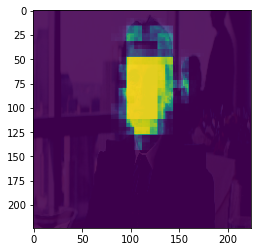

In [30]:
plt.imshow(test_img)
plt.imshow(pred_mask,alpha=0.9)